### Baseline Text Data Augmentation Methods

Compare and supplement advanced method with baseline traditional (easy to implement methods).


### Prepare Environment

In [1]:
import random
from numpy.random import seed
from random import shuffle
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
seed(156)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [4]:
# Install required nltk resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# Importing required libraries
import pandas as pd
from tqdm.std import tqdm
from IPython.display import display, HTML
from nltk.corpus import wordnet
import time
import re

### Load Data

In [17]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance',
    'mechanical or equipment issue'
    ]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]

sample_name = f'df_train_trues_{focus_cat}' 
reports = pd.read_csv(f"01_data/prepared/{sample_name}.csv", dtype=str)  
reports

Pick a category: ppe non-compliance


,Unnamed: 0,text,category
0,9,foreign body entered employee left eye whilst ...,1
1,58,worker observed without appropriate fall prote...,1
2,188,worker reported there was a very strong gust o...,1
3,197,worker reported there was a very strong gust o...,1
4,1071,whillst cleaning a ceiling ventilation grill d...,1
...,...,...,...
110,36536,other fall to lower level six to ten feet whil...,1
111,38002,other fall to lower level unspecified a worker...,1
112,45012,caught in running equipment or machinery durin...,1
113,49331,fall through surface or existing opening six t...,1


In [18]:
# Remove unecessary columns.
reports = reports[['text', 'category']]
reports

,text,category
0,foreign body entered employee left eye whilst ...,1
1,worker observed without appropriate fall prote...,1
2,worker reported there was a very strong gust o...,1
3,worker reported there was a very strong gust o...,1
4,whillst cleaning a ceiling ventilation grill d...,1
...,...,...
110,other fall to lower level six to ten feet whil...,1
111,other fall to lower level unspecified a worker...,1
112,caught in running equipment or machinery durin...,1
113,fall through surface or existing opening six t...,1


### Simple Text Augmentation Techniques

Jason W Wei and Kai Zou. 2019. Eda: Easy data augmentation techniques for boosting perfor- mance on text classification tasks. arXiv preprint arXiv:1901.11196.

- Synonym Replacement (SR)
- Random Deletion (RD)
- Random Swap (RS)
- Random Insertion (RI)

In [8]:
# Modifications Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: CC-BY-NC-4.0
# Original Copyright https://github.com/jasonwei20/eda_nlp

# stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our',
              'ours', 'ourselves', 'you', 'your', 'yours',
              'yourself', 'yourselves', 'he', 'him', 'his',
              'himself', 'she', 'her', 'hers', 'herself',
              'it', 'its', 'itself', 'they', 'them', 'their',
              'theirs', 'themselves', 'what', 'which', 'who',
              'whom', 'this', 'that', 'these', 'those', 'am',
              'is', 'are', 'was', 'were', 'be', 'been', 'being',
              'have', 'has', 'had', 'having', 'do', 'does', 'did',
              'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
              'because', 'as', 'until', 'while', 'of', 'at',
              'by', 'for', 'with', 'about', 'against', 'between',
              'into', 'through', 'during', 'before', 'after',
              'above', 'below', 'to', 'from', 'up', 'down', 'in',
              'out', 'on', 'off', 'over', 'under', 'again',
              'further', 'then', 'once', 'here', 'there', 'when',
              'where', 'why', 'how', 'all', 'any', 'both', 'each',
              'few', 'more', 'most', 'other', 'some', 'such', 'no',
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too',
              'very', 's', 't', 'can', 'will', 'just', 'don',
              'should', 'now', '']

def get_only_chars(line):
    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ")  # replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +', ' ', clean_line)  # delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line



# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            # print("replaced", random_word, "with", synonym)
            num_replaced += 1
        if num_replaced >= n:  # only replace up to n words
            break

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return new_words


def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)



# Random deletion
# Randomly delete words from the sentence with probability p
def random_deletion(words, p):
    # obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    # randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    # if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words) - 1)
        return [words[rand_int]]

    return new_words


# Random swap
# Randomly swap two words in the sentence n times
def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words


def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words) - 1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words) - 1)
        counter += 1
        if counter > 3:
            return new_words
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words


# Random insertion
# Randomly insert n words into the sentence
def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words


def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words) - 1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words) - 1)
    new_words.insert(random_idx, random_synonym)



# main data augmentation function
def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
    sentence = get_only_chars(sentence)
    words = sentence.split(' ')
    words = [word for word in words if word is not '']
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug / 4) + 1
    n_sr = max(1, int(alpha_sr * num_words))
    n_ri = max(1, int(alpha_ri * num_words))
    n_rs = max(1, int(alpha_rs * num_words))

    # synonym replacement
    for _ in range(num_new_per_technique):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(' '.join(a_words))

    # random insertion
    for _ in range(num_new_per_technique):
        a_words = random_insertion(words, n_ri)
        augmented_sentences.append(' '.join(a_words))

    # randown swap
    for _ in range(num_new_per_technique):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(' '.join(a_words))

    # random deletion
    for _ in range(num_new_per_technique):
        a_words = random_deletion(words, p_rd)
        augmented_sentences.append(' '.join(a_words))

    augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
    shuffle(augmented_sentences)

    # trim so that we have the desired number of augmented sentences
    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

    return augmented_sentences

In [9]:
def gen_eda(in_df, alpha, num_aug=1):

    #in_df.reset_index(inplace=True)
    lines = in_df.text
    labels = in_df.category
    out_sens = []
    
    for i, line in tqdm(enumerate(lines)):        
        label = int(labels[i])
        if label == 1:
            sentence = line
            aug_sentence = eda(sentence, alpha_sr=alpha, alpha_ri=alpha, alpha_rs=alpha, p_rd=alpha, num_aug=num_aug)
            out_sens.extend(aug_sentence)

    out_df = pd.DataFrame(out_sens, columns = ['text'])    
    out_df['category'] = 1
    return(out_df)

### Perfrom Data Augmentation

In [10]:
# Printing long descriptions in Colab can be messy as they don't wrap
# Create simple function to split lines to set length
def split_input(user_string, chunk_size):
    output = []
    words = user_string.split(" ")
    total_length = 0

    while (total_length < len(user_string) and len(words) > 0):
        line = []
        next_word = words[0]
        line_len = len(next_word) + 1

        while (line_len < chunk_size) and len(words) > 0:
            words.pop(0)
            line.append(next_word)

            if (len(words) > 0):
                next_word = words[0]
                line_len += len(next_word) + 1

        line = " ".join(line)
        output.append(line)
        total_length += len(line) 

    print('\n')
    for chunk in output: 
        print(chunk)

In [19]:
# Generate data for augmentation
target_num_of_augs = 8000
num_of_augs = ceil(target_num_of_augs / len(reports))
df_eda = gen_eda(reports, alpha = 0.1, num_aug=num_of_augs)

# Compare augmented to original (for first narrative)
# to visually inspect augmentation
split_input(reports.text[0], 80)
split_input(df_eda.text.iloc[0], 80)

115it [00:07, 16.13it/s]



foreign body entered employee left eye whilst adjusting ligatures on a
pedestal a gust of wind has blown a foreign object into an employee left eye
note the ip was wearing safety glasses at the time of the incident the
employee flushed his eye out at the nearest eyewash station reported to his
supervisor the employee was then escorted to the paramedic to get have his
left eye irrigated


foreign body entered employee left eye whilst adjusting ligatures on a
pedestal a gust of wind has blown a foreign target into an employee left eye
notation the information science was wearing safety spectacles at the time of
the incident the employee flushed his eye out at the nearest eyewash post
reported to his supervisor the employee was then escorted to the paramedic to
contract have his left eye irrigated


In [20]:
# Now visually inspect a random sample of 20
table = df_eda.sample(20)
display(HTML(table.to_html()))

,text,category
769,employee scratched the back of his left hand whilst refine a pump shaft incident employee scratched the back of his left hand whilst resolve the refine on a pump shaft it was account that as he justfinished the refine and was displace away in the same gesticulate he glanced an object scratching the back of his hand fitter was not wearing gloves as arguaby there was no need at the point in clip when the case occurred first aid was selfadministered technician immediately returned to body of work with no further action required see detailed verbal description,1
6416,the employee on irritation to her eye after accidentally a dry chemical fire extinguisher the employee the returning discharging dry chemical fire extinguisher to the toolroom and and the process of offloading the extinguisher the employee accidentally onsite it due to the employee not being inserted when pin was placed the extinguisher on the ground she depressed the discharge lever causing a small amount of extinguishing agent to be released onto the ground safety surrounding environment the employee was not wearing time glasses at the medical and felt some irritation to her to eye notifications were made to supervision and her the employee flushed hsse eyes at hsse and trailer and taken to offsite occupational clinic as a precaution the in was released employee no restrictions at a followup appointment on two million one hundred and twenty two treatment with twenty one actualpotential decision was based felt employee receiving a first aid thousand and released with no restrictions notifications were made onsite supervision and discharged the employee flushed her eyes and left medical trailer and taken to offsite occupational clinic as a precaution,1
5575,hit middle thumb on left hand with a hammering taken to hospital for x ray distal phalange thumb bung bone is fractured in three places whilst fitting a trading floor plate for a new gate the ip was trying to align the linchpin bolts with a hammering he was holding the bolt with his left hand outwear heavy tariff leather gauntlet character gloves he hit it twice without incidental but on the rd stroke he missed slightly and hit the middle thumb on his left hand a heavy blow as there was no blood he tried to continue but it turn too terrible whereupon he reported the incidental to a senior hsse advisor email from william oconnell regarding this incidental one hundred and ten one thousand three hundred and this was not rear as a riddor as the ip was capable to continue duties commensurate with his role he returned to cultivate where he was restricted for cultivate for the first phoebe days and then went off sick with a virus so reappraisal did not occur for another week after attending the fracture clinic he could not initially wear gloves but could continue with mechanical cultivate except the enceinte cultivate ie use of hammering and could continue with pat testing and desk duties the ip was taken to hospital as the nail bruising was significant and the thumb could not be tidy without stark bother the x ray point three crack in the distal phalange thumb bung bone he was given two x thirty one thousand phoebe hundred mg cocodamol mg of codeine mg paracetamol these are prescription only drugs the ip came game to the cultivate and has been interview the ip finished at cultivate as planned and early reading are he will return to cultivate on monday,1
2502,the employee climbed up the back of the ramp up to pull out wire for lighting in a bathroom the employee was observed with out any fall security at and raising of some eight feet incidental on tuesday july six two m and xvi at two and thirty pm at the carpenter pe ramp up a uei employee climbed up the back of the ramp up to pull out wire for lighting in a bathroom the employee was observed with out any fall security at and raising of some eight feet uei was a subcontractor on this job for infinity ramp up services see detailed description,1
4289,em

In [21]:
# Check the the number of fake narrratives (should be n x unique prompt count)
rep_count = len(df_eda)
print('No. of fabricated reports: ', rep_count)

# Now write the fake data to the 'fabricated' subfolder of the data folder
# This data will be used for transformer-based data augmentation (TrDA)
df_eda.to_csv(f'01_data/fabricated/{focus_cat}_{rep_count}_simple_da.csv', index=False)

No. of fabricated reports:  8050


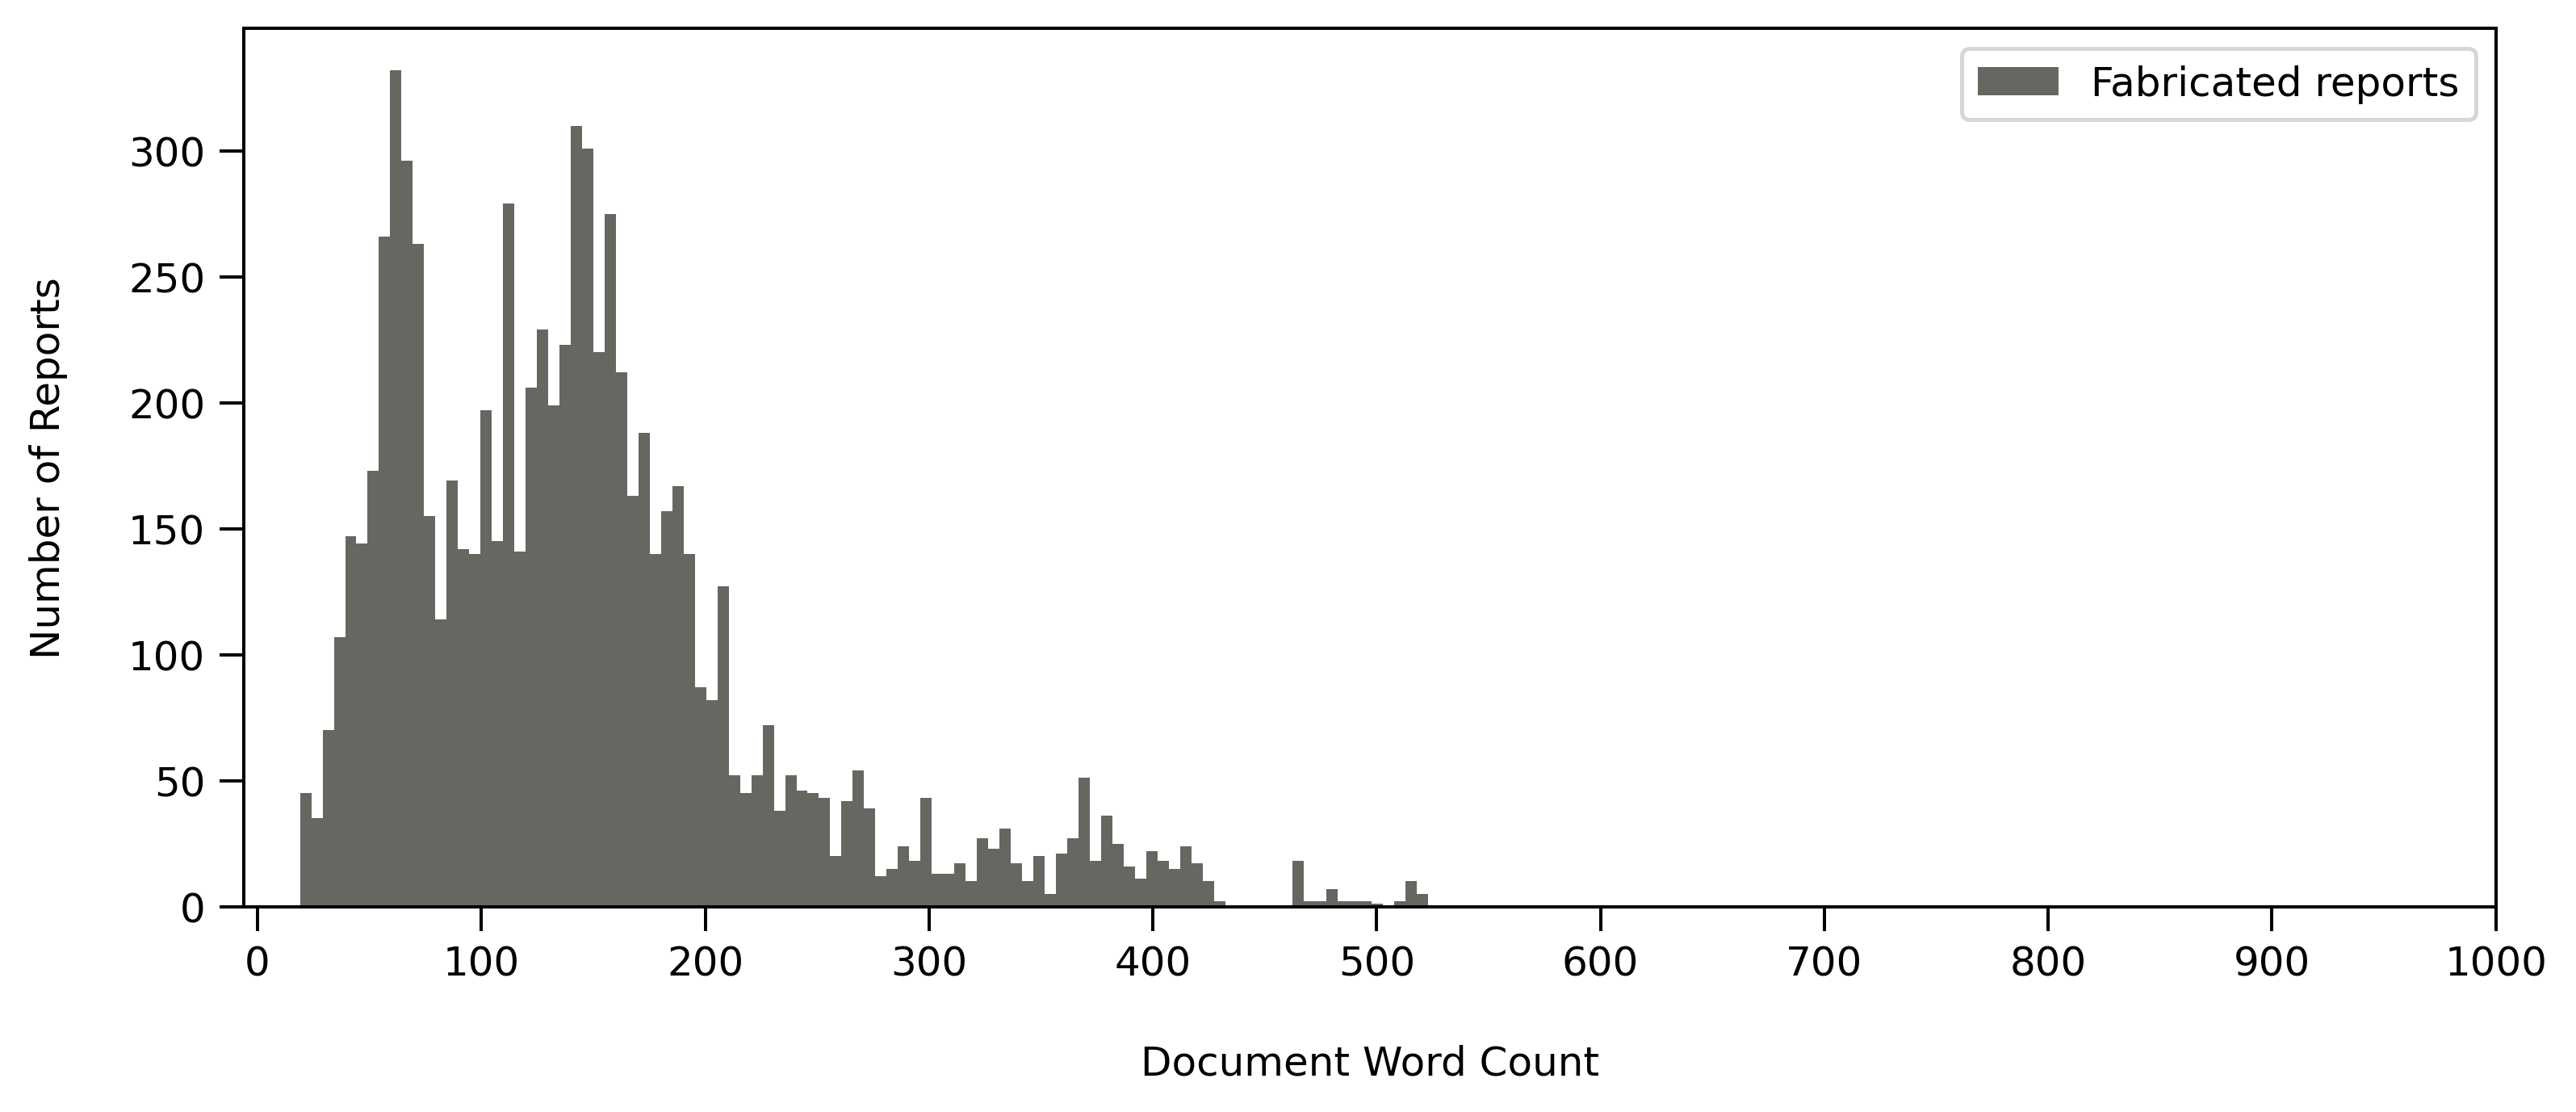

In [22]:
# Plot a histogram of word counts in the fake narratives
# Remember the real raw data has a mean word count of 62 and 95 percentile value of 309 words
# We expect to see similar distribution for the fake narratives...
doc_lens = [len(d.split()) for d in df_eda.text]
plt.figure(figsize=(10, 4), dpi=360)
plt.hist(doc_lens, bins = 100, color='#26261e', alpha=0.7, label = 'Fabricated reports')
plt.legend(loc = 'upper right')

plt.xlabel("Document Word Count", labelpad = 15)
plt.ylabel("Number of Reports", labelpad = 15)
plt.tick_params(size=6)
plt.xticks(np.linspace(0, 1000, 11))
plt.title('', fontdict=dict(size=10))
plt.show()